<a href="https://colab.research.google.com/github/johanhoffman/DD2365_VT23/blob/main/template-report-Navier-Stokes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **The Navier-Stokes equations**
**Johan Hoffman**

# **Abstract**

In this report, flow past a cylinder simulated using FEM at different speeds with different Reynold numbers are compared. Also, the impact of different mesh resolutions on the simulation is studied.

# **About the code**

In [ ]:
"""This program is an example file for the course"""
"""DD2365 Advanced Computation in Fluid Mechanics, """
"""KTH Royal Institute of Technology, Stockholm, Sweden."""

# Copyright (C) 2020 Johan Hoffman (jhoffman@kth.se)

# This file is part of the course DD2365 Advanced Computation in Fluid Mechanics
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This template is maintained by Johan Hoffman
# Please report problems to jhoffman@kth.se

'KTH Royal Institute of Technology, Stockholm, Sweden.'

# **Set up environment**

In [ ]:
# Load neccessary modules.
from google.colab import files

import numpy as np
import time

# Install FEniCS (this may take a long time)
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install-real.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

from dolfin import *; from mshr import *

import dolfin.common.plotting as fenicsplot

from matplotlib import pyplot as plt

# **Introduction**

In this report, we look at the Navier-Stokes equations, which have the form
$$\dot u + (u\cdot \nabla)u + \nabla p - \nu\Delta u = f,\\ \nabla \cdot u=0. $$ If we define the Reynolds number $Re$ as
$$Re = \frac{UL}{ν},$$
we can write the equation as $$
\dot u + (u\cdot \nabla)u + \nabla p - Re^{-1}\Delta u = f,\\ \nabla \cdot u=0
$$
In this lab, we simulate a rectangular domain, with a circular hole in the domain, with a flow from left to right. Then, the inflow speed of the fluid can be varied to get different Reynolds numbers.

Also, the drag and lift coefficients (Lecture 3, p. 60) for the cylinder can be computed using $$c_D = \frac{2F_D}{\rho U^2D}
$$
and $$
c_L = \frac{2F_L}{\rho U^2D},$$
where $F_D$ and $F_L$ is the drag and lift force on the cylinder respectively. Also $\rho$ is a density, $U$ is a velocity and $D$ the diameter of the cylinder.

The Strohal number (Lecture 3, p. 61) can also be computed as
$$
St = \frac{fL}{U},
$$
where $f$ is the frequency of the vortex shedding (which is equal to the frequency of the occillating lift force). Also $U$ is a velocity and $L$ is the diameter of the cylinder.

# **Method**

## **Reynolds number**
In this section, the inflow velocity is changed to get different Reynolds numbers. This is done by changing the inflow parameter

```
uin = 1
```
to the value we want. We know that the Reynolds number is defined as $$
Re = \frac{UD}{\nu}.
$$
We have that the viscosity $\nu$ is set as $$\nu = 4\cdot 10^{-3}$$
and that $D$ is the diameter of the cylinder, which is $$
D = 2\cdot 0.2 = 0.4.
$$
We get that the velocity $U$ is given by $$
U = \frac{Re ⋅ \nu}{D}.
$$
Therefore, we get the inflow velocities from the reynold numbers $Re=1,10,100,1000$ as shown in Table 1.

\begin{array}{ |c|c| }
 \hline
 \textbf{Reynolds number Re} & \textbf{Inflow velocity U}  \\
 \hline
 1 & 0.01 \\
 \hline
 10 & 0.1  \\
 \hline
 100 & 1  \\
 \hline
 100 & 10  \\
 \hline
\end{array}
***Table 1: Inflow velocity U for Reynolds number Re = 1,10,100,1000***


For the largest inflow value, the timestep of the simulation must also be made smaller to get a solution that converges.

## **Lift, drag and strouhal's number**
In this section, we want to compute the lift and drag cofficients of the flow at the same Reynold number as above. We know that the coefficients are given by  $$
c_D = \frac{2F_D}{\rho U^2D}
$$
and $$
c_L = \frac{2F_L}{\rho U^2D},
$$
where $$
\rho = 1
$$
and D is the diameter of the cylinder $$
D = 2 \cdot 0.2 = 0.4.
$$

We also plot the force on the cylinder, and by setting

```
phi_x = 1.0
phi_y = 0.0
```
we get the drag force $F_D$ and by setting


```
phi_x = 0.0
phi_y = 1.0
```
we get the lift force $F_L.$ We also know that the Strohaul number is computed by $$
St = \frac{fL}{U},
$$
where the characteristic length is $$L = 0.4.$$ The frequency $f$ of the vortex shedding can be found by looking at the occilations of the lift force.

## **Mesh resolution**

Here, we compare the simulation for Reynolds number $Re = 100,$ when changing the size of the mesh. This is done by changing

```
resolution = 32

```

 We look at meshes of resolution $$h=\frac{1}{8},\frac{1}{16},\frac{1}{32}.$$ To compare these, we computre the lift and drag cofficients of the flow, as well as the Strouhal number.


**Define domain and mesh**

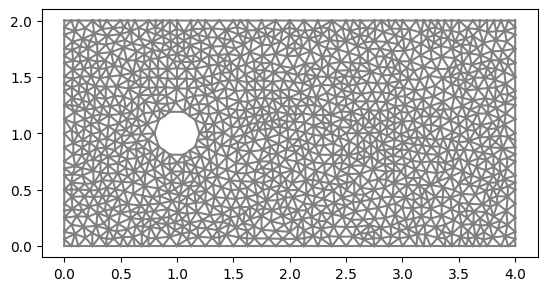

In [ ]:
# Define rectangular domain
L = 4
H = 2

# Define circle
xc = 1.0
yc = 0.5*H
rc = 0.2

# Define subdomains (for boundary conditions)
class Left(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], 0.0)

class Right(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], L)

class Lower(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], 0.0)

class Upper(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], H)

left = Left()
right = Right()
lower = Lower()
upper = Upper()

# Generate mesh (examples with and without a hole in the mesh)
resolution = 32
#mesh = RectangleMesh(Point(0.0, 0.0), Point(L, H), L*resolution, H*resolution)
mesh = generate_mesh(Rectangle(Point(0.0,0.0), Point(L,H)) - Circle(Point(xc,yc),rc), resolution)

# Local mesh refinement (specified by a cell marker)
no_levels = 0
for i in range(0,no_levels):
  cell_marker = MeshFunction("bool", mesh, mesh.topology().dim())
  for cell in cells(mesh):
    cell_marker[cell] = False
    p = cell.midpoint()
    if p.distance(Point(xc, yc)) < 1.0:
        cell_marker[cell] = True
  mesh = refine(mesh, cell_marker)

# Define mesh functions (for boundary conditions)
boundaries = MeshFunction("size_t", mesh, mesh.topology().dim()-1)
boundaries.set_all(0)
left.mark(boundaries, 1)
right.mark(boundaries, 2)
lower.mark(boundaries, 3)
upper.mark(boundaries, 4)

plt.figure()
plot(mesh)
plt.show()

**Define finite element approximation spaces**

In [ ]:
# Generate finite element spaces (for velocity and pressure)
V = VectorFunctionSpace(mesh, "Lagrange", 1)
Q = FunctionSpace(mesh, "Lagrange", 1)

# Define trial and test functions
u = TrialFunction(V)
p = TrialFunction(Q)
v = TestFunction(V)
q = TestFunction(Q)

**Define boundary conditions**

In [ ]:
# Define boundary conditions
class DirichletBoundaryLower(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[1], 0.0)

class DirichletBoundaryUpper(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[1], H)

class DirichletBoundaryLeft(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], 0.0)

class DirichletBoundaryRight(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], L)

class DirichletBoundaryObjects(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and (not near(x[0], 0.0)) and (not near(x[0], L)) and (not near(x[1], 0.0)) and (not near(x[1], H))

dbc_lower = DirichletBoundaryLower()
dbc_upper = DirichletBoundaryUpper()
dbc_left = DirichletBoundaryLeft()
dbc_right = DirichletBoundaryRight()
dbc_objects = DirichletBoundaryObjects()

# Examples of time dependent and stationary inflow conditions
#uin = Expression('4.0*x[1]*(1-x[1])', element = V.sub(0).ufl_element())
#uin = Expression('1.0 + 1.0*fabs(sin(t))', element = V.sub(0).ufl_element(), t=0.0)
uin = 1
bcu_in0 = DirichletBC(V.sub(0), uin, dbc_left)
bcu_in1 = DirichletBC(V.sub(1), 0.0, dbc_left)
bcu_upp0 = DirichletBC(V.sub(0), 0.0, dbc_upper)
bcu_upp1 = DirichletBC(V.sub(1), 0.0, dbc_upper)
bcu_low0 = DirichletBC(V.sub(0), 0.0, dbc_lower)
bcu_low1 = DirichletBC(V.sub(1), 0.0, dbc_lower)
bcu_obj0 = DirichletBC(V.sub(0), 0.0, dbc_objects)
bcu_obj1 = DirichletBC(V.sub(1), 0.0, dbc_objects)

pin = Expression('5.0*fabs(sin(t))', element = Q.ufl_element(), t=0.0)
pout = 0.0
#bcp0 = DirichletBC(Q, pin, dbc_left)
bcp1 = DirichletBC(Q, pout, dbc_right)

#bcu = [bcu_in0, bcu_in1, bcu_upp0, bcu_upp1, bcu_low0, bcu_low1, bcu_obj0, bcu_obj1]
bcu = [bcu_in0, bcu_in1, bcu_upp1, bcu_low1, bcu_obj0, bcu_obj1]
bcp = [bcp1]

# Define measure for boundary integration
ds = Measure('ds', domain=mesh, subdomain_data=boundaries)

# **Results**

In this section, the result of the different simulations are found.

## **Reynolds number**

Below are the velocity for a few different values of the time t (beginning, middle and end of the simulation) for the four different Reynolds numbers.

![picture](http://drive.google.com/uc?export=view&id=1eKerWdf15UAFTUCrJjkU8AGexzcD16O5)

***Fig 1: Velocity for 3 different times for Re=1***
![picture](http://drive.google.com/uc?export=view&id=1SA4k40JSUXVm9dHG7fFiEvpHyESaRBG5)

***Fig 2: Velocity for  different times for Re=10***
![picture](http://drive.google.com/uc?export=view&id=1iRM7N_Q1KvUhyPOj7Ddwvw-RLC9Aoigg)

***Fig 3: Velocity for 4 different times for Re=100***
![picture](http://drive.google.com/uc?export=view&id=1ojIJT3RNOYxiiFlVFJOPW2Ff3PXdPst6)

***Fig 4: Velocity for 4 different times for Re=1000***

For the two lowest Reynolds numbers, 1 and 10, the flow is steady, since it does not change significantly during the simulation. When it has reached a certain velocity, the apperance of the flow stays constant. We can see this by looking at Figure 1 and 2. For the larger Reynolds numbers, 100 and 1000, it changes over time, as can be seen in Figure 3 and 4, and is therefore unsteady.

## **Lift, drag and strouhal's number**
Here, we look at the same Reynold numbers as before, and compute the lift and drag coefficients, as well as the Strouhal numbers for the different flows. To do this, we look at the lift and drag forces acting on the cylinder in the x- and y-direction. The plot of the forces can be found in Figure 5, and the result of the computations in Table 2.

![picture](http://drive.google.com/uc?export=view&id=1X366z7KEb6i5uZh1HXdZDDv2Ag4i9UBv)

***Fig 5: Lift forces (upper row) and drag forces (lower row) for Reynold numbers Re = 1,10,100,1000***

\begin{array}{ |c|c|c|c| }
 \hline
 \textbf{Reynolds number,} Re & \textbf{Drag coefficient}, c_D &\textbf{Lift coefficient}, c_L & \textbf{Strouhal number,} St  \\
 \hline
 1 & 1.25 &8.125 \cdot 10^{-3} &-\\
 \hline
 10 & 1.3 &0.01425& 0.057 \\
 \hline
 100 & 4.4  &1.05 &0.18667 \\
 \hline
 100 & 83.5 &35.0&0.2 \\
 \hline
\end{array}
***Table 2: Lift and drag coefficients, and Strouhal number for different Reynold numbers Re = 1,10,100,1000***

As we can see, both the lift and drag coefficient increases with increasing Reynolds numbers. We can also see that the lift coefficient is smaller than the drag coefficient in all of the cases.

The Strouhal number is of the right size, about 0.2 for the cases where we can se a von Karman vortex street (for Re =100 and Re=1000), and it is smaller for Re = 10. For Re = 1, we have no occilating force and no vortex shedding, so we can not compute a Strouhal number.

## **Mesh resolution**
Here, we look at the fixed Reynolds number Re = 100, and look at the solution for mesh resolution $h=1/8, 1/16, 1/32.$ We also compare the lift and drag coefficients, as well as the Strouhal numbers, as can be seen in Table 3. The resulting pressure and velocities can be seen in Figure 6, and the drag and lift forces in Figure 7.

![picture](http://drive.google.com/uc?export=view&id=1jjnXu5EwAtFFR4fhy5c5YDZWWItnd2Gy)
***Fig 6: Pressure (upper row) and velocity (lower row) for Re = 100 with mesh resolutions h = 1/8, 1/16, 1/32***

![picture](http://drive.google.com/uc?export=view&id=1LP7U9HSAL8FT7jyClD_9Ux7c-Zpoa3ob)
***Fig 7: Drag forces (upper row) and lift forces (lower row) for Re = 100 with mesh resolutions h = 1/8, 1/16, 1/32***


\begin{array}{ |c|c|c|c| }
 \hline
 \textbf{Resolution} h & \textbf{Drag coefficient}, c_D &\textbf{Lift coefficient}, c_L & \textbf{Strouhal number,} St  \\
 \hline
 1/8 & 15.25 &0.1 &-\\
 \hline
 1/16 & 10.5&1& 0.24 \\
 \hline
 1/32 & 4.4  &1.05 &0.18667 \\
 \hline
\end{array}
***Table 3: Lift and drag coefficients, and Strouhal number for Re = 100 with mesh resolutions h = 1/8, 1/16, 1/32***

We can see that no visible vortex shedding happens for resolution $h=1/8,$ and therefore no Strouhal number was computed. For both $h=1/16$ and $h=1/32,$ we can see that a von Katman vortex street forms, and the Strouhal number is close to the expexted number. Also, the drag coefficient get smaller when increasing the resolution, and the lift coefficient gets smaller.  





**Define flow parameters**

In [ ]:
# Set viscosity
nu = 4.0e-3

**Define method parameters**

In [ ]:
# Define iteration functions
# (u0,p0) solution from previous time step
# (u1,p1) linearized solution at present time step
u0 = Function(V)
u1 = Function(V)
p0 = Function(Q)
p1 = Function(Q)

# Set parameters for nonlinear and lienar solvers
num_nnlin_iter = 5
prec = "amg" if has_krylov_solver_preconditioner("amg") else "default"

# Time step length
#dt = 0.05*mesh.hmin() # for Re=1000
dt = 0.5*mesh.hmin()

**Define variational problem**

In [ ]:
# Define variational problem

# Stabilization parameters
h = CellDiameter(mesh);
u_mag = sqrt(dot(u1,u1))
d1 = 1.0/sqrt((pow(1.0/dt,2.0) + pow(u_mag/h,2.0)))
d2 = h*u_mag

# Mean velocities for trapozoidal time stepping
um = 0.5*(u + u0)
um1 = 0.5*(u1 + u0)

# Momentum variational equation on residual form
Fu = inner((u - u0)/dt + grad(um)*um1, v)*dx - p1*div(v)*dx + nu*inner(grad(um), grad(v))*dx \
    + d1*inner((u - u0)/dt + grad(um)*um1 + grad(p1), grad(v)*um1)*dx + d2*div(um)*div(v)*dx
au = lhs(Fu)
Lu = rhs(Fu)

# Continuity variational equation on residual form
Fp = d1*inner((u1 - u0)/dt + grad(um1)*um1 + grad(p), grad(q))*dx + div(um1)*q*dx
ap = lhs(Fp)
Lp = rhs(Fp)

**Compute force on boundary**

In [ ]:
# Define the direction of the force to be computed
phi_x = 1.0
phi_y = 0.0

#psi_expression = Expression(("0.0","pow(x[0]-0.5,2.0) + pow(x[1]-1.0,2.0) - pow(0.2,2.0) < 1.e-5 ? 1. : 0."), element = V.ufl_element())
psi_expression = Expression(("near(pow(x[0]-xc,2.0) + pow(x[1]-yc,2.0) - pow(rc,2.0), 0.0) ? phi_x : 0.","near(pow(x[0]-xc,2.0) + pow(x[1]-yc,2.0) - pow(rc,2.0), 0.0) ? phi_y : 0."), xc=xc, yc=yc, rc=rc, phi_x=phi_x, phi_y=phi_y, element = V.ufl_element())
psi = interpolate(psi_expression, V)

Force = inner((u1 - u0)/dt + grad(um1)*um1, psi)*dx - p1*div(psi)*dx + nu*inner(grad(um1), grad(psi))*dx

#plt.figure()
#plot(psi, title="weight function psi")

# Force normalization
D = 2*rc
normalization = -2.0/D

**Set plotting variables and open export files**

In [ ]:
# Open files to export solution to Paraview
file_u = File("results-NS/u.pvd")
file_p = File("results-NS/p.pvd")

# Set plot frequency
plot_time = 0
plot_freq = 10

# Force computation data
force_array = np.array(0.0)
force_array = np.delete(force_array, 0)
time = np.array(0.0)
time = np.delete(time, 0)
start_sample_time = 1.0

**Time stepping algorithm**

Time t = 0.03285506167650246
Time t = 0.03285506167650246


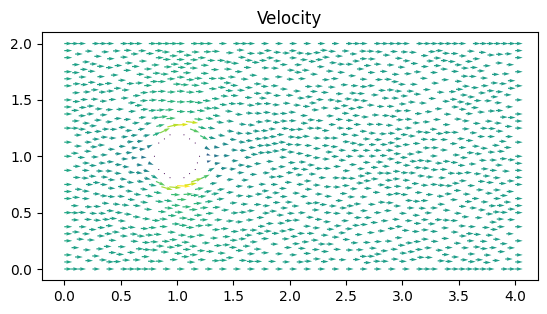

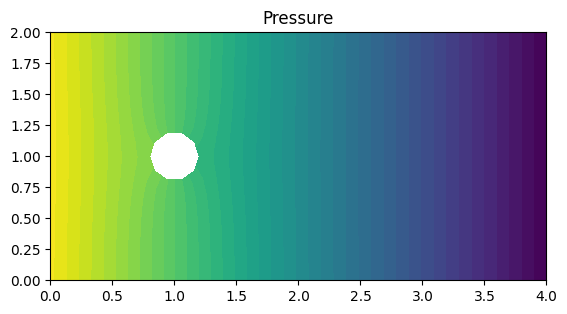

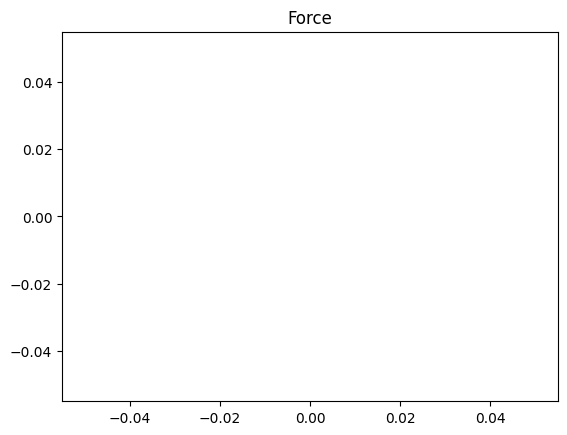

Time t = 0.06571012335300493
Time t = 0.0985651850295074
Time t = 0.13142024670600985
Time t = 0.1642753083825123
Time t = 0.19713037005901476
Time t = 0.22998543173551722
Time t = 0.2628404934120197
Time t = 0.2956955550885222
Time t = 0.3285506167650247
Time t = 0.36140567844152716
Time t = 0.39426074011802964
Time t = 0.4271158017945321
Time t = 0.4599708634710346
Time t = 0.4928259251475371
Time t = 0.5256809868240395
Time t = 0.558536048500542
Time t = 0.5913911101770444
Time t = 0.6242461718535468
Time t = 0.6571012335300492
Time t = 0.6899562952065517
Time t = 0.7228113568830541
Time t = 0.7556664185595565
Time t = 0.788521480236059
Time t = 0.8213765419125614
Time t = 0.8542316035890638
Time t = 0.8870866652655662
Time t = 0.9199417269420687
Time t = 0.9527967886185711
Time t = 0.9856518502950735
Time t = 1.018506911971576
Time t = 1.0513619736480784
Time t = 1.0842170353245808
Time t = 1.1170720970010832
Time t = 1.1499271586775857
Time t = 1.182782220354088
Time t = 1.2156372

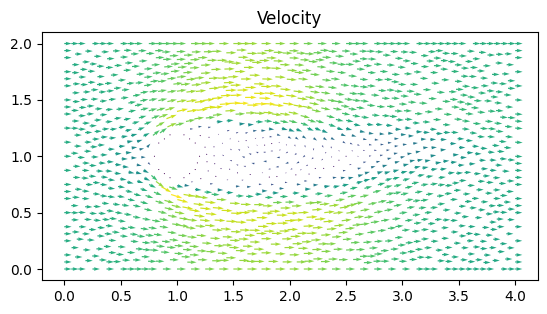

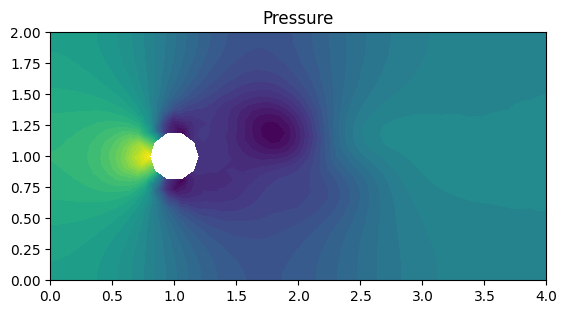

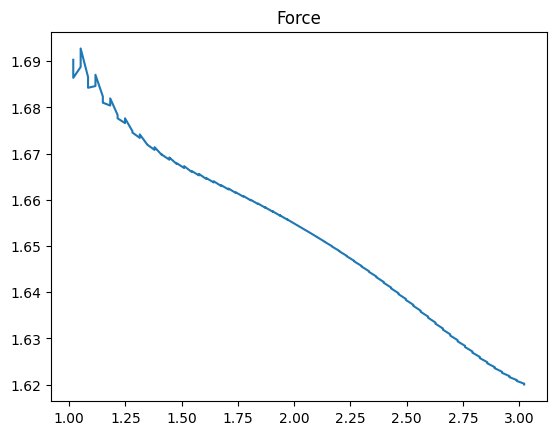

Time t = 3.0555207359147336
Time t = 3.0883757975912363
Time t = 3.121230859267739
Time t = 3.1540859209442416
Time t = 3.186940982620744
Time t = 3.219796044297247
Time t = 3.2526511059737495
Time t = 3.285506167650252
Time t = 3.318361229326755
Time t = 3.3512162910032575
Time t = 3.38407135267976
Time t = 3.4169264143562628
Time t = 3.4497814760327654
Time t = 3.482636537709268
Time t = 3.5154915993857707
Time t = 3.5483466610622734
Time t = 3.581201722738776
Time t = 3.6140567844152787
Time t = 3.6469118460917813
Time t = 3.679766907768284
Time t = 3.7126219694447866
Time t = 3.7454770311212893
Time t = 3.778332092797792
Time t = 3.8111871544742946
Time t = 3.844042216150797
Time t = 3.8768972778273
Time t = 3.9097523395038025
Time t = 3.942607401180305
Time t = 3.975462462856808
Time t = 4.00831752453331
Time t = 4.041172586209813
Time t = 4.074027647886315
Time t = 4.106882709562818
Time t = 4.139737771239321
Time t = 4.172592832915823
Time t = 4.205447894592326
Time t = 4.238302

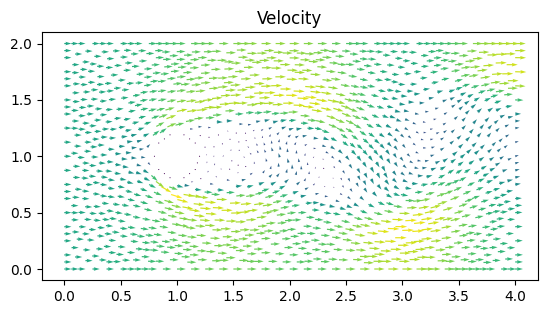

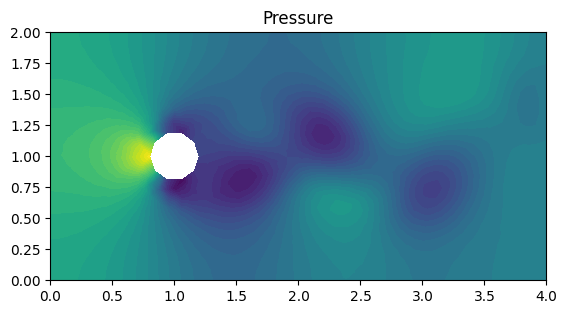

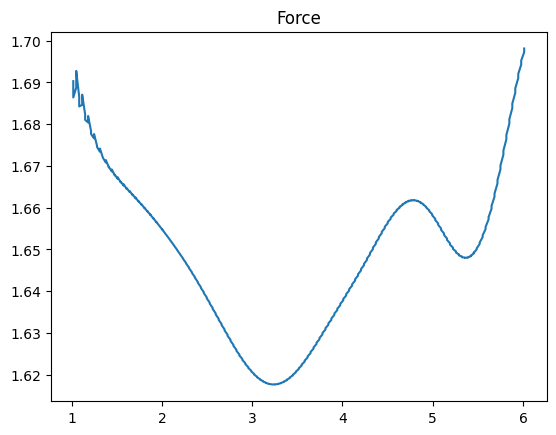

Time t = 6.045331348476474
Time t = 6.078186410152977
Time t = 6.11104147182948
Time t = 6.143896533505982
Time t = 6.176751595182485
Time t = 6.209606656858988
Time t = 6.24246171853549
Time t = 6.275316780211993
Time t = 6.308171841888496
Time t = 6.341026903564998
Time t = 6.373881965241501
Time t = 6.4067370269180035
Time t = 6.439592088594506
Time t = 6.472447150271009
Time t = 6.5053022119475115
Time t = 6.538157273624014
Time t = 6.571012335300517
Time t = 6.603867396977019
Time t = 6.636722458653522
Time t = 6.669577520330025
Time t = 6.702432582006527
Time t = 6.73528764368303
Time t = 6.768142705359533
Time t = 6.800997767036035
Time t = 6.833852828712538
Time t = 6.866707890389041
Time t = 6.899562952065543
Time t = 6.932418013742046
Time t = 6.965273075418549
Time t = 6.998128137095051
Time t = 7.030983198771554
Time t = 7.0638382604480565
Time t = 7.096693322124559
Time t = 7.129548383801062
Time t = 7.1624034454775645
Time t = 7.195258507154067
Time t = 7.22811356883057
T

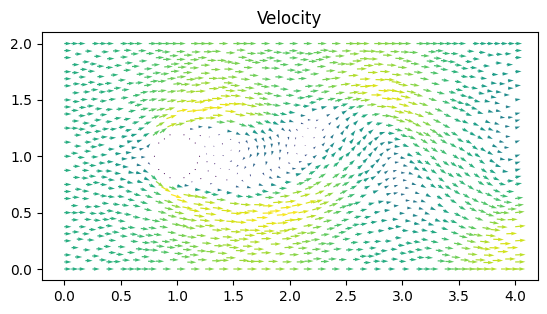

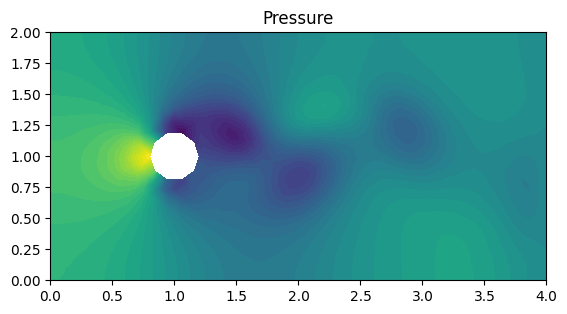

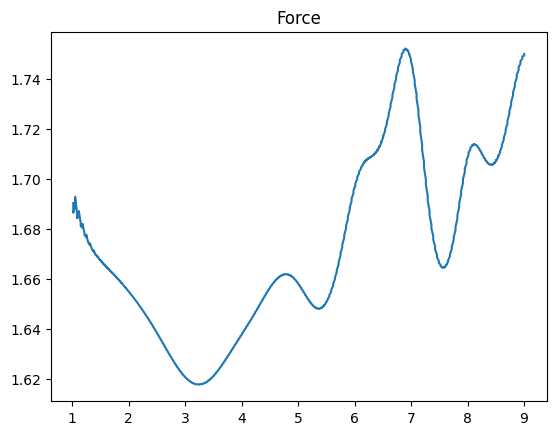

Time t = 9.035141961038187
Time t = 9.067997022714689
Time t = 9.10085208439119
Time t = 9.133707146067692
Time t = 9.166562207744194
Time t = 9.199417269420696
Time t = 9.232272331097198
Time t = 9.2651273927737
Time t = 9.297982454450201
Time t = 9.330837516126703
Time t = 9.363692577803205
Time t = 9.396547639479707
Time t = 9.429402701156208
Time t = 9.46225776283271
Time t = 9.495112824509212
Time t = 9.527967886185714
Time t = 9.560822947862215
Time t = 9.593678009538717
Time t = 9.626533071215219
Time t = 9.65938813289172
Time t = 9.692243194568222
Time t = 9.725098256244724
Time t = 9.757953317921226
Time t = 9.790808379597728
Time t = 9.82366344127423
Time t = 9.856518502950731
Time t = 9.889373564627233
Time t = 9.922228626303735
Time t = 9.955083687980236
Time t = 9.987938749656738
Time t = 10.02079381133324
Time t = 10.053648873009742
Time t = 10.086503934686244
Time t = 10.119358996362745
Time t = 10.152214058039247
Time t = 10.185069119715749
Time t = 10.21792418139225
Ti

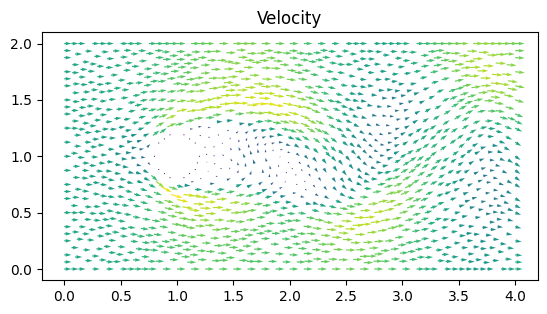

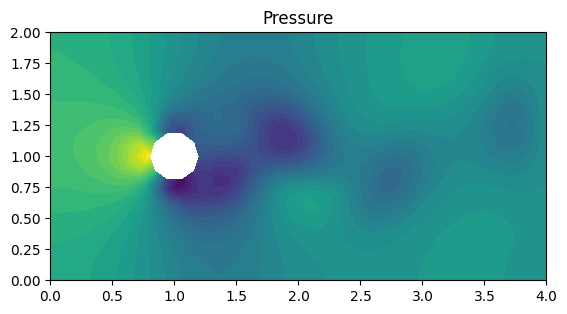

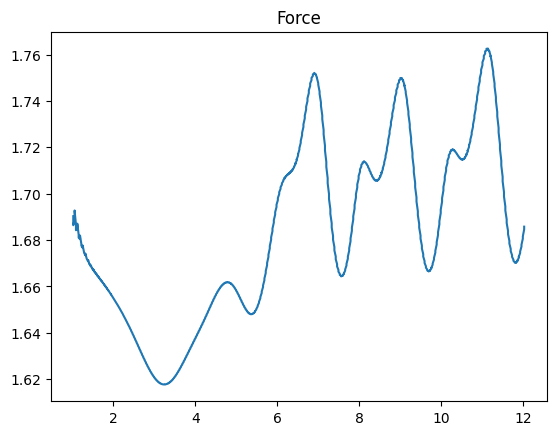

Time t = 12.05780763527635
Time t = 12.090662696952851
Time t = 12.123517758629353
Time t = 12.156372820305855
Time t = 12.189227881982356
Time t = 12.222082943658858
Time t = 12.25493800533536
Time t = 12.287793067011862
Time t = 12.320648128688363
Time t = 12.353503190364865
Time t = 12.386358252041367
Time t = 12.419213313717869
Time t = 12.45206837539437
Time t = 12.484923437070872
Time t = 12.517778498747374
Time t = 12.550633560423876
Time t = 12.583488622100377
Time t = 12.61634368377688
Time t = 12.649198745453381
Time t = 12.682053807129883
Time t = 12.714908868806384
Time t = 12.747763930482886
Time t = 12.780618992159388
Time t = 12.81347405383589
Time t = 12.846329115512392
Time t = 12.879184177188893
Time t = 12.912039238865395
Time t = 12.944894300541897
Time t = 12.977749362218399
Time t = 13.0106044238949
Time t = 13.043459485571402
Time t = 13.076314547247904
Time t = 13.109169608924406
Time t = 13.142024670600907
Time t = 13.17487973227741
Time t = 13.207734793953911


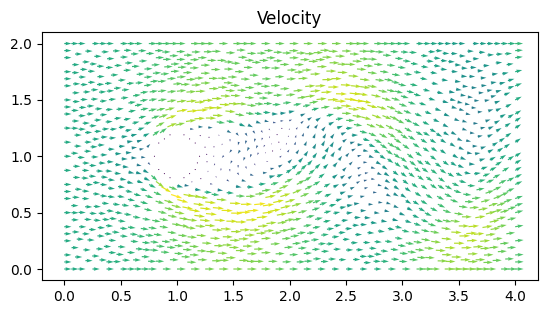

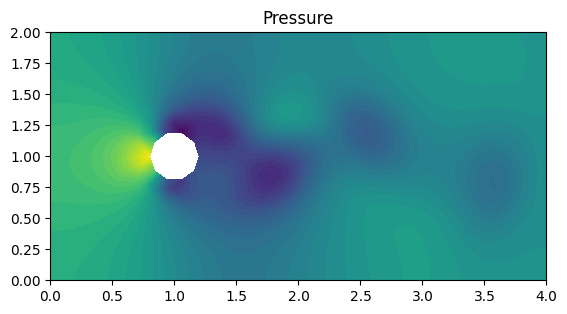

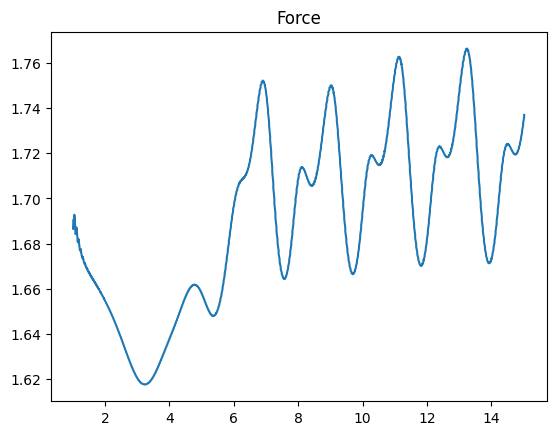

Time t = 15.04761824783801
Time t = 15.080473309514511
Time t = 15.113328371191013
Time t = 15.146183432867515
Time t = 15.179038494544017
Time t = 15.211893556220518
Time t = 15.24474861789702
Time t = 15.277603679573522
Time t = 15.310458741250024
Time t = 15.343313802926525
Time t = 15.376168864603027
Time t = 15.409023926279529
Time t = 15.44187898795603
Time t = 15.474734049632533
Time t = 15.507589111309034
Time t = 15.540444172985536
Time t = 15.573299234662038
Time t = 15.60615429633854
Time t = 15.639009358015041
Time t = 15.671864419691543
Time t = 15.704719481368045
Time t = 15.737574543044547
Time t = 15.770429604721048
Time t = 15.80328466639755
Time t = 15.836139728074052
Time t = 15.868994789750554
Time t = 15.901849851427055
Time t = 15.934704913103557
Time t = 15.967559974780059
Time t = 16.000415036456562
Time t = 16.033270098133066
Time t = 16.06612515980957
Time t = 16.098980221486073
Time t = 16.131835283162577
Time t = 16.16469034483908
Time t = 16.197545406515584

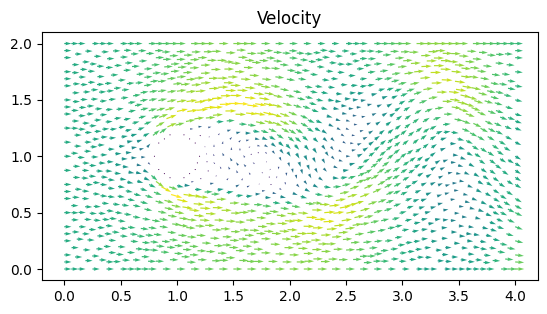

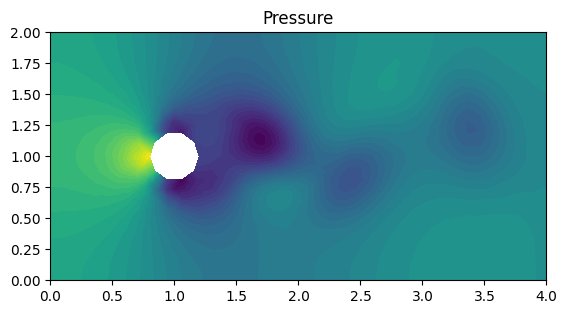

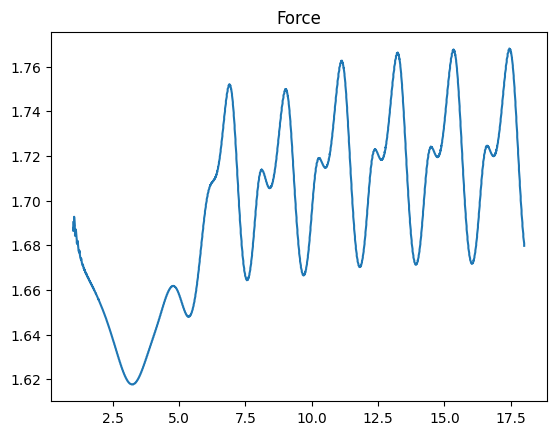

Time t = 18.037428860399782
Time t = 18.070283922076285
Time t = 18.10313898375279
Time t = 18.135994045429292
Time t = 18.168849107105796
Time t = 18.2017041687823
Time t = 18.234559230458803
Time t = 18.267414292135307
Time t = 18.30026935381181
Time t = 18.333124415488314
Time t = 18.365979477164817
Time t = 18.39883453884132
Time t = 18.431689600517824
Time t = 18.464544662194328
Time t = 18.49739972387083
Time t = 18.530254785547335
Time t = 18.56310984722384
Time t = 18.595964908900342
Time t = 18.628819970576846
Time t = 18.66167503225335
Time t = 18.694530093929853
Time t = 18.727385155606356
Time t = 18.76024021728286
Time t = 18.793095278959363
Time t = 18.825950340635867
Time t = 18.85880540231237
Time t = 18.891660463988874
Time t = 18.924515525665377
Time t = 18.95737058734188
Time t = 18.990225649018385
Time t = 19.023080710694888
Time t = 19.05593577237139
Time t = 19.088790834047895
Time t = 19.1216458957244
Time t = 19.154500957400902
Time t = 19.187356019077406
Time t

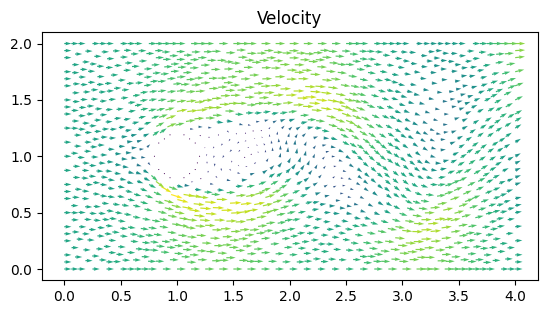

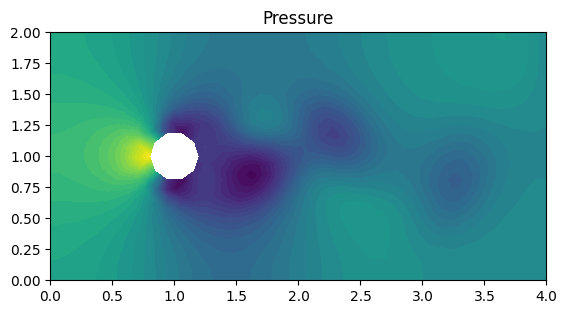

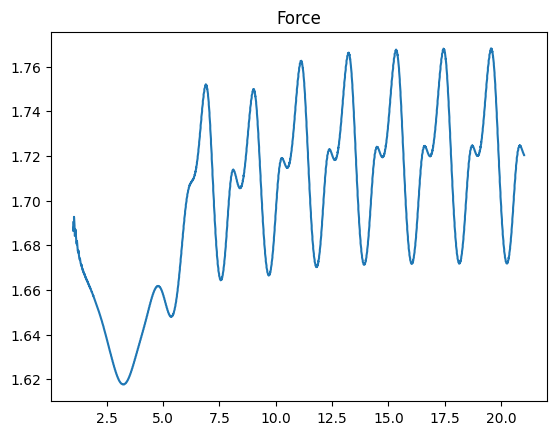

Time t = 21.060094534638107
Time t = 21.09294959631461
Time t = 21.125804657991115
Time t = 21.158659719667618
Time t = 21.19151478134412
Time t = 21.224369843020625
Time t = 21.25722490469713
Time t = 21.290079966373632
Time t = 21.322935028050136
Time t = 21.35579008972664
Time t = 21.388645151403143
Time t = 21.421500213079646
Time t = 21.45435527475615
Time t = 21.487210336432653
Time t = 21.520065398109157
Time t = 21.55292045978566
Time t = 21.585775521462164
Time t = 21.618630583138668
Time t = 21.65148564481517
Time t = 21.684340706491675
Time t = 21.717195768168178
Time t = 21.75005082984468
Time t = 21.782905891521185
Time t = 21.81576095319769
Time t = 21.848616014874192
Time t = 21.881471076550696
Time t = 21.9143261382272
Time t = 21.947181199903703
Time t = 21.980036261580207
Time t = 22.01289132325671
Time t = 22.045746384933214
Time t = 22.078601446609717
Time t = 22.11145650828622
Time t = 22.144311569962724
Time t = 22.177166631639228
Time t = 22.21002169331573
Time t

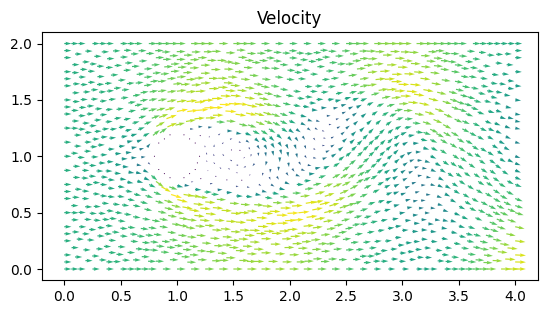

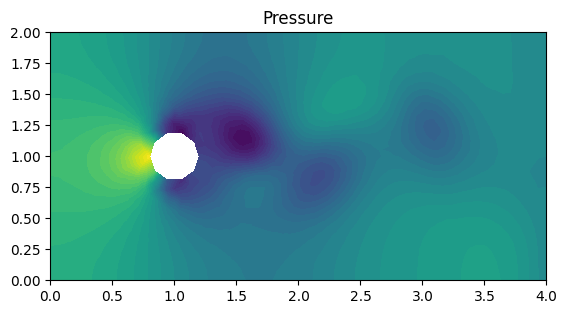

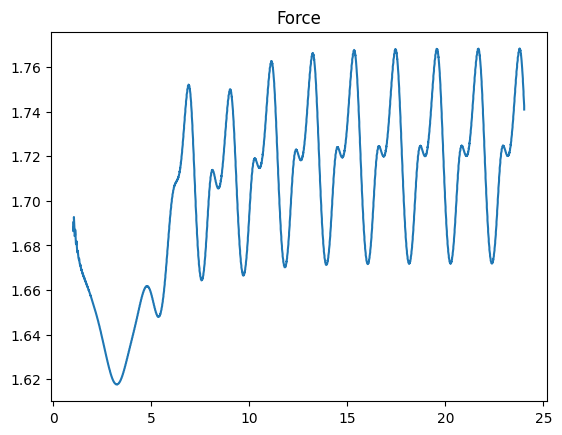

Time t = 24.04990514719993
Time t = 24.082760208876433
Time t = 24.115615270552937
Time t = 24.14847033222944
Time t = 24.181325393905944
Time t = 24.214180455582447
Time t = 24.24703551725895
Time t = 24.279890578935454
Time t = 24.312745640611958
Time t = 24.34560070228846
Time t = 24.378455763964965
Time t = 24.41131082564147
Time t = 24.444165887317972
Time t = 24.477020948994475
Time t = 24.50987601067098
Time t = 24.542731072347483
Time t = 24.575586134023986
Time t = 24.60844119570049
Time t = 24.641296257376993
Time t = 24.674151319053497
Time t = 24.70700638073
Time t = 24.739861442406504
Time t = 24.772716504083007
Time t = 24.80557156575951
Time t = 24.838426627436014
Time t = 24.871281689112518
Time t = 24.90413675078902
Time t = 24.936991812465525
Time t = 24.96984687414203
Time t = 25.002701935818532
Time t = 25.035556997495036
Time t = 25.06841205917154
Time t = 25.101267120848043
Time t = 25.134122182524546
Time t = 25.16697724420105
Time t = 25.199832305877553
Time t =

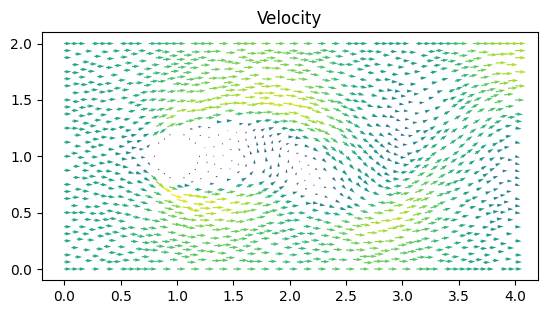

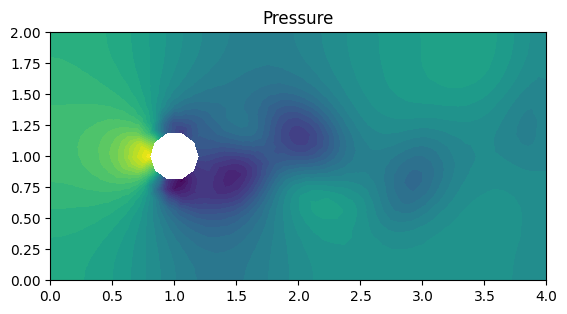

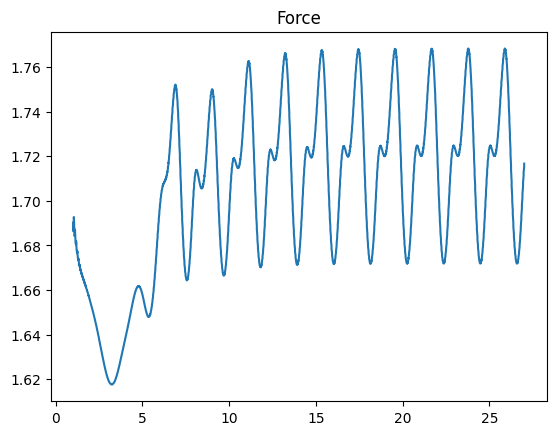

Time t = 27.03971575976175
Time t = 27.072570821438255
Time t = 27.10542588311476
Time t = 27.138280944791262
Time t = 27.171136006467766
Time t = 27.20399106814427
Time t = 27.236846129820773
Time t = 27.269701191497276
Time t = 27.30255625317378
Time t = 27.335411314850283
Time t = 27.368266376526787
Time t = 27.40112143820329
Time t = 27.433976499879794
Time t = 27.466831561556297
Time t = 27.4996866232328
Time t = 27.532541684909305
Time t = 27.565396746585808
Time t = 27.59825180826231
Time t = 27.631106869938815
Time t = 27.66396193161532
Time t = 27.696816993291822
Time t = 27.729672054968326
Time t = 27.76252711664483
Time t = 27.795382178321333
Time t = 27.828237239997836
Time t = 27.86109230167434
Time t = 27.893947363350843
Time t = 27.926802425027347
Time t = 27.95965748670385
Time t = 27.992512548380354
Time t = 28.025367610056858
Time t = 28.05822267173336
Time t = 28.091077733409865
Time t = 28.12393279508637
Time t = 28.15678785676287
Time t = 28.189642918439375
Time t 

In [ ]:
!rm results-NS/*

# Time stepping
T = 30
t = dt
while t < T + DOLFIN_EPS:

    s = 'Time t = ' + repr(t)
    print(s)

    pin.t = t
    #uin.t = t

    # Solve non-linear problem
    k = 0
    while k < num_nnlin_iter:

        # Assemble momentum matrix and vector
        Au = assemble(au)
        bu = assemble(Lu)

        # Compute velocity solution
        [bc.apply(Au, bu) for bc in bcu]
        [bc.apply(u1.vector()) for bc in bcu]
        solve(Au, u1.vector(), bu, "bicgstab", "default")

        # Assemble continuity matrix and vector
        Ap = assemble(ap)
        bp = assemble(Lp)

        # Compute pressure solution
        [bc.apply(Ap, bp) for bc in bcp]
        [bc.apply(p1.vector()) for bc in bcp]
        solve(Ap, p1.vector(), bp, "bicgstab", prec)

        # Compute force
        F = assemble(Force)
        if (t > start_sample_time):
          force_array = np.append(force_array, normalization*F)
          time = np.append(time, t)

        k += 1

    if t > plot_time:

        s = 'Time t = ' + repr(t)
        print(s)

        # Save solution to file
        file_u << u1
        file_p << p1

        # Plot solution
        plt.figure()
        plot(u1, title="Velocity")

        plt.figure()
        plot(p1, title="Pressure")

        plot_time += T/plot_freq

        plt.show()

        plt.figure()
        plt.title("Force")
        plt.plot(time, force_array)
        plt.show()

    # Update time step
    u0.assign(u1)
    t += dt

#!tar -czvf results-NS.tar.gz results-NS
#files.download('results-NS.tar.gz')

# **Discussion**

In this report, a finite element simulation of a flow past a cylinder was simulated at different Reynolds numbers and different mesh resolutions. As expected, a von Karman vortex street formed for high Reynold numbers, and the expected Strouhal number was found for these cases. Also, the resolution impacted the emergence of vortex shedding for Re = 100, where the von Karman vortex street was not visible for the lowest resolution.